<style>
    pre {
        white-space: pre-wrap;
        word-wrap: break-word;
    }
</style>

<div style="display:flex; justify-content:space-around; align-items:center; background-color:#cccccc; padding:5px; border:2px solid #333333;">
    <a href="https://www.um.es/web/estudios/grados/ciencia-ingenieria-datos/" target="_blank">
    <img src="https://www.um.es/documents/1073494/42130150/LogosimboloUMU-positivo.png" alt="UMU" style="height:200px; width:auto;">
    <a href="https://estudios.upct.es/grado/5251/inicio" target="_blank">
    <img src="https://www.upct.es/contenido/universidad/galeria/identidad-2021/logos/logos-upct/marca-upct/marca-principal/horizontal/azul.png" alt="UPCT" style="height:145px; width:auto;">
</div>

# Asignatura: **Deep Learning**

## Titulación: **Grado en Ciencia e Ingeniería de Datos**

## Práctica 2: Redes Convolucionales
### **Sesión 2/3: La arquitectura U-Net**

**Autores**: Antonio Martínez Sánchez, Juan Morales Sánchez, José Luís Sancho Gómez y Juan Antonio Botía Blaya

<div style="page-break-before: always;"></div>

### Contenidos
- [Requisitos](#requisitos)
- [La arquitectura U-Net](#unet)
- [El dataset](#dataset)
- [Restauración de imágenes](#restauración)
- [Entrenamiento](#entrenamiento)
- [Ejercicios](#ejercicios)

### Requisitos
<a class='anchor' id='requisitos'></a>

Se trabajará con notebooks de [Jupyter](https://jupyter.org/install) con código Python empleando como intérprete la última versión de [Miniconda](https://docs.anaconda.com/miniconda/). Se requiere la preinstalación (se recomienda utilizar [pip](https://pypi.org/project/pip/)) de los siguientes paquetes de Python:

- [Numpy](https://pypi.org/project/numpy/) (computación numérica)
- [Scipy](https://pypi.org/project/scipy/) (computación científica)
- [Tensorflow](https://www.tensorflow.org/install/pip?hl=es-419#linux) que incluye a Keras (deep Learning)
- [Scikit-learn](https://pypi.org/project/scikit-learn/) (machine Learning)
- [Mrcfile](https://pypi.org/project/mrcfile/) (operationes E/S en ficheros MRC)
- [Matplotlib](https://pypi.org/project/matplotlib/) (visualización de datos)

Además, para la visualización 3D se recomienda la utilización de [Paraview](https://www.paraview.org/).

### La arquitectura U-Net
<a class='anchor' id='unet'></a>

En algunas tareas de análisis de imagen es necesario trabajar a nivel de píxel en lugar de tomar una decisión, p.e.  clasificación, analizando el conjunto de la imagen. Por esto se requiere de una arquitectura encoder-decoder, es decir primero un encoder analiza el contenido de la imagen y depués un decoder reconstruye la imagen resultante, la cual tendrá el mismo tamaño y estructura que la de entrada. Esta arquitectura se corresponde con la de un autoencoder, que se estudiará con detalle en la Práctica 4. El problema de los autoencoders para imágenes es que la información es comprimida en gran medida durante la fase de codificación (encoder) que un decoder no puede reconstruir con precisión por si solo. Para conseguir una reconstrucción con precisión a nivel de píxel en U-Net se introdujeron conexiones directas (skip connections) entre las diferentes capas del encoder y las capas correspondientes del decoder. Más información sobre esta red, incluyendo un video explicativo, disponible en la web de los autores [https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

En esta sesión de prácticas vamos a construir una red U-Net para restaurar imágenes altamente ruidosas de cryo-EM.

### El dataset
<a class='anchor' id='dataset'></a>

Se procesarán imágenes almacenadas en ficheros en formato MRC. Para leer este formato de almacenamiento se necesita el paquete *mrcfile*. A modo de ejemplo sobre su uso se proporcional la siguiente función tomada del repositorio [PolNet](https://github.com/anmartinezs/polnet/blob/506309bb815d395131c97100272ce47b5c07d2d3/polnet/lio.py#L17C1-L32C20):

```python
import mrcfile

def load_mrc(fname, mmap=False, no_saxes=True):
    """
    Load an input MRC tomogram as ndarray

    :param fname: the input MRC
    :param mmap: if True (default False) the data are read as a memory map
    :param no_saxes: if True (default) then X and Y axes are swaped to cancel the swaping made by mrcfile package
    :return: a ndarray (or memmap is mmap=True)
    """
    if mmap:
        mrc = mrcfile.mmap(fname, permissive=True, mode='r+')
    else:
        mrc = mrcfile.open(fname, permissive=True, mode='r+')
    if no_saxes:
        return np.swapaxes(mrc.data, 0, 2)
    return mrc.data
```

El directorio con las imágenes es *imgs/SNR_high*, con un contenido similar al de la sesión anterior pero ahora las imágenes son mucho más ruidosas. El subdirectorio *noisy* contine las imágenes ruidosas y *clean* contiene la imágenes sin ruido, necesarias para poder realizar un aprendizaje supervisado.

El formato MRC se utiliza para almacenar tomografías y pilas de imágenes, esto es imágenes 3D. En este caso, los archivos contienen una sola imagen 2D con diferentes tamaños. Antes de construir los tensores de entrada para la red, las imágenes se tienen que recortar para que todas tengan un tamaño 56x56 píxeles, es importante que se mantenga la parte central de la imagen durante el recorte. 

### Restauración de imágenes
<a class='anchor' id='restauracion'></a>

En esta sesión se resolverá el problema de la restauración de imágenes empleando una red U-Net. En algunos dominios de aplicación, como la microscopía electrónica, las imágenes sufren distorsiones y ruido introducidos por los sistemas de adquisición. La restauración consiste en eliminar <u>en la medida de lo posible</u> estas distorsiones y ruido para recuperar una imagen que permita una mejor visualización del contenido de la escena que hay en la imagen.

En el artículo [DeepFinder](https://doi.org/10.1038/s41592-021-01275-4) se describe una red neuronal con arquitectura U-Net empleada para procesar tomograma, imágenes 3D. La siguiente imagen resume su arquitectura:

![DeepFinder](deepfinder_unet.png)

En esta práctica se utilizar esta arquitectura como referencia para construir una red U-Net para la restauración de imágenes


### Entrenamiento
<a class='anchor' id='entrenamiento'></a>

En cualquier algoritmo de machine learning el reto durante el entramiento es que el algoritmo aprenda pero sin llegar a sobre ajustarse a los datos de entrenamiento. Es por esto que es frecuente añadir suficientes épocas durante el entrenamiento hasta que se produzca el sobreajuste, el problema es que el modelo final resultado del entrenamiento estará sobre ajustado. 

Existen varias estrategias para obtener modelos aproximadamente óptimos, cuando la función de pérdidas llega al mínimo durante el entrenamiento. Una es fijar las épocas para asegurar sobreajuste y durante el entrenamiento ir guardando modelos intermedios, esta opción requiere disponer del espacio para ir almacenando los modelos con suficiente precisión. Otra estrategia fácilmente implementable usando tensorflow es el mecanismo de parada anticipada o *early stopping*, en este caso se utilizan funciones que monitorizan el proceso de entrenamiento para que se detenga si se dan unas ciertas condiciones.

### Ejercicios
<a class='anchor' id='ejercicios'></a>

**E1:** Carga las imágenes de entrada del directorio y preprocésalas según se especifica en la sección [El dataset](#dataset). Almacénalas en tensores con las dimensiones adecuadas para servir de entrada y/o salida una red U-Net.

**E2:** Aleatoriza la posicion de las imágenes y consecuentemente los identificadores.

**E3:** Particiona los tensores de entrada en dos, asigna el 80% de las imágenes para el entrenamiento y el 20% para la validación.

**E4:** Adapta la arquitectura mostrada en la sección [Restauración de imágenes](#restauracion) red para resolver la tarea de restauración de las imágenes cargadas en el ejercicio anterior.

**E5:** Entrénala teniendo en cuenta la función de perdidas que mejor se ajusta al problema de restauración propuesto. Fija unos parámetros que te permitan conseguir sobreajuste.

**E6:** Visualiza algunos ejemplos de imágenes restauradas comparadas con las imágenes de partida y las imágenes sin distorsiones. ¿Se consigue eliminar el ruido? ¿Se consigue restaurar perfectamente la estructura de la molécula original?

**E7:** Repite los ejercicios E5 e E6 pero añadiendo unos mecanismos de parada temprana para evitar la aparición de sobre ajuste. ¿Cuánto dura ahora el entrenamiento? ¿Se ha conseguido un mejor resultado? ¿Por qué?

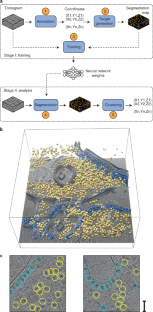

In [ ]:

import mrcfile


def load_mrc(fname, mmap=False, no_saxes=True):
    """
    Load an input MRC tomogram as ndarray
    :param fname: the input MRC
    :param mmap: if True (default False) the data are read as a memory map
    :param no_saxes: if True (default) then X and Y axes are swapped to cancel the swapping made by mrcfile package
    :return: a ndarray (or memmap if mmap=True)
    """
    if mmap:
        mrc = mrcfile.mmap(fname, permissive=True, mode='r+')
    else:
        mrc = mrcfile.open(fname, permissive=True, mode='r+')
    if no_saxes:
        return np.swapaxes(mrc.data, 0, 2)
    return mrc.data


def center_crop(image, size=56):
    """
    Crop the center of the image to the desired size.
    """
    h, w, _ = image.shape
    start_h = (h - size) // 2
    start_w = (w - size) // 2
    return image[start_h:start_h + size, start_w:start_w + size]


In [ ]:
def load_dataset(noisy_path, clean_path, size=56):
    """
    Load MRC images from directories and preprocess them.
    :param noisy_path: Path to noisy images
    :param clean_path: Path to clean images
    :param size: Target crop size
    :return: Tuple of numpy arrays (noisy_images, clean_images)
    """
    print("Loading dataset...")
    noisy_images, clean_images = [], []
    
    noisy_files = sorted(os.listdir(noisy_path))
    clean_files = sorted(os.listdir(clean_path))
    
    for noisy_file, clean_file in zip(noisy_files, clean_files):
        if noisy_file.endswith('.mrc') and clean_file.endswith('.mrc'):
            noisy_img = load_mrc(os.path.join(noisy_path, noisy_file))
            clean_img = load_mrc(os.path.join(clean_path, clean_file))
            
            noisy_img = center_crop(noisy_img, size)
            clean_img = center_crop(clean_img, size)
            
            noisy_images.append(noisy_img.astype(np.float32))
            clean_images.append(clean_img.astype(np.float32))
    print("Dataset loaded.")
    
    return np.array(noisy_images), np.array(clean_images)

# Uso del código
noisy_dir = "../data/SNR_low/noisy"
clean_dir = "../data/SNR_low/clean"
noisy_dataset, clean_dataset = load_dataset(noisy_dir, clean_dir)


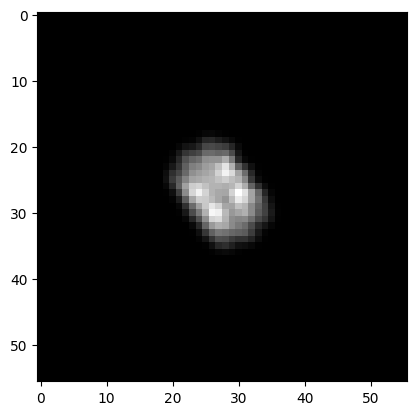

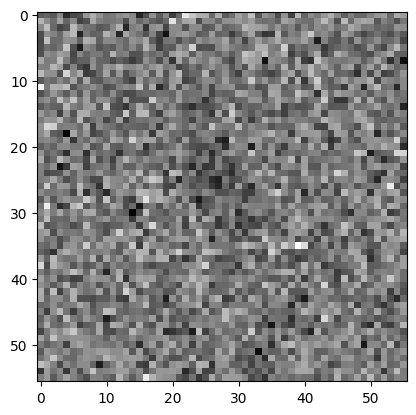

In [14]:
from matplotlib import pyplot as plt
plt.imshow(clean_dataset[0, :, :, 0], cmap='gray')
plt.show()
plt.imshow(noisy_dataset[0, :, :, 0], cmap='gray')
